In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import shutil
import zipfile
import os
import requests
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [4]:
!kaggle datasets download alphiree/cardiovascular-diseases-risk-prediction-dataset

 21%|███████▊                              | 1.00M/4.87M [00:00<00:00, 4.95MB/s]
100%|██████████████████████████████████████| 4.87M/4.87M [00:00<00:00, 16.4MB/s]


In [5]:
!kaggle datasets download sulianova/cardiovascular-disease-dataset

100%|████████████████████████████████████████| 742k/742k [00:00<00:00, 1.73MB/s]
100%|████████████████████████████████████████| 742k/742k [00:00<00:00, 1.73MB/s]


In [6]:
# Nombre del archivo ZIP que deseas mover, extraer y eliminar
archivos_zip = ["cardiovascular-diseases-risk-prediction-dataset.zip",
                "cardiovascular-disease-dataset.zip"]
for archivo_zip in archivos_zip:
    # Ruta del archivo ZIP actual
    ruta_zip = os.path.abspath(archivo_zip)

    # Ruta de la carpeta de destino
    carpeta_destino = "Datasets"

    # Mover el archivo ZIP a la carpeta de destino
    shutil.move(ruta_zip, os.path.join(carpeta_destino, archivo_zip))

    # Ruta completa del archivo ZIP en la carpeta de destino
    ruta_zip_destino = os.path.join(carpeta_destino, archivo_zip)

    # Descomprimir el archivo ZIP en la carpeta de destino
    with zipfile.ZipFile(ruta_zip_destino, 'r') as zip_ref:
        zip_ref.extractall(carpeta_destino)

    # Eliminar el archivo ZIP
    os.remove(ruta_zip_destino)

    print(f"Archivo {archivo_zip} movido, extraído y eliminado.")

Archivo cardiovascular-diseases-risk-prediction-dataset.zip movido, extraído y eliminado.
Archivo cardiovascular-disease-dataset.zip movido, extraído y eliminado.


# Cargar y preprocesar los datos

In [7]:
# Carga el archivo CSV en un DataFrame de pandas
data = pd.read_csv('Datasets/CVD_cleaned.csv', sep=',')
data2 = pd.read_csv('Datasets/cardio_train.csv', sep=';')
columnas_1 = data.columns
columnas_2 = data2.columns

In [8]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [9]:
data2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
print(columnas_1)

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')


In [11]:
data.columns = ['Salud_General', 'Chequeo', 'Ejercicio', 'Enfermedad_Cardíaca', 'Cáncer_de_Piel',
                'Otros_Cánceres', 'Depresión', 'Diabetes', 'Artritis', 'Sexo',
                'Categoría_de_Edad', 'Altura_(cm)', 'Peso_(kg)', 'IMC', 'Historial_de_Tabaco',
                'Consumo_de_Alcohol', 'Consumo_de_Frutas',
                'Consumo_de_Vegetales_Verdes', 'Consumo_de_Papas_Fritas']

In [12]:
data["Consumo_de_Alcohol"] = data["Consumo_de_Alcohol"].apply(
    lambda x: 1 if x > 15 else 0)
data["Historial_de_Tabaco"] = data["Historial_de_Tabaco"].replace({
                                                                  'Yes': 1, 'No': 0})
data["Sexo"] = data["Sexo"].replace({'Male': 1, 'Female': 2})
data["Enfermedad_Cardíaca"] = data["Enfermedad_Cardíaca"].replace({
                                                                  'Yes': 1, 'No': 0})
data["Ejercicio"] = data["Ejercicio"].replace({'Yes': 1, 'No': 0})

In [13]:
data2.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [14]:
data2.columns = ['id', 'Categoría_de_Edad', 'Sexo', 'Altura_(cm)', 'Peso_(kg)', 'ap_hi', 'ap_lo',
                 'colesterol', 'glucosa', 'Historial_de_Tabaco', 'Consumo_de_Alcohol', 'Ejercicio', 'Enfermedad_Cardíaca']

In [15]:
data.head()

,Salud_General,Chequeo,Ejercicio,Enfermedad_Cardíaca,Cáncer_de_Piel,Otros_Cánceres,Depresión,Diabetes,Artritis,Sexo,Categoría_de_Edad,Altura_(cm),Peso_(kg),IMC,Historial_de_Tabaco,Consumo_de_Alcohol,Consumo_de_Frutas,Consumo_de_Vegetales_Verdes,Consumo_de_Papas_Fritas
0,Poor,Within the past 2 years,0,0,No,No,No,No,Yes,2,70-74,150.0,32.66,14.54,1,0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,No,No,No,Yes,No,2,70-74,165.0,77.11,28.29,0,0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,No,No,No,Yes,No,2,60-64,163.0,88.45,33.47,0,0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,No,No,No,Yes,No,1,75-79,180.0,93.44,28.73,0,0,30.0,30.0,8.0
4,Good,Within the past year,0,0,No,No,No,No,No,1,80+,191.0,88.45,24.37,1,0,8.0,4.0,0.0


In [16]:
data2 = data2.drop(['id', 'Categoría_de_Edad'], axis=1)

In [71]:
column_join = data.columns.intersection(data2.columns)
dataset = pd.concat([data[column_join], data2[column_join]], axis=0)
columnas = dataset.columns

In [72]:
dataset

,Ejercicio,Enfermedad_Cardíaca,Sexo,Altura_(cm),Peso_(kg),Historial_de_Tabaco,Consumo_de_Alcohol
0,0,0,2,150.0,32.66,1,0
1,0,1,2,165.0,77.11,0,0
2,1,0,2,163.0,88.45,0,0
3,1,1,1,180.0,93.44,0,0
4,0,0,1,191.0,88.45,1,0
...,...,...,...,...,...,...,...
69995,1,0,2,168.0,76.00,1,0
69996,1,1,1,158.0,126.00,0,0
69997,0,1,2,183.0,105.00,0,1
69998,0,1,1,163.0,72.00,0,0


In [73]:
# Dividir en set de entrenamiento y set de prueba con las categorías más relacionadas

y = dataset['Enfermedad_Cardíaca']
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(dataset[['Ejercicio', 'Sexo', 'Altura_(cm)', 'Peso_(kg)',
                                                             'Historial_de_Tabaco', 'Consumo_de_Alcohol']], y, train_size=0.70, random_state=85, stratify=y)

y_train = y_train.replace(3, 1)
y_test = y_test.replace(3, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(265197, 6) (265197,) (113657, 6) (113657,)


In [74]:
from sklearn.preprocessing import StandardScaler

columnas = dataset.columns

# Estandarización
scaler = StandardScaler().fit(X_train)
data_scaled = scaler.transform(X_train)

In [75]:
# Creación de un nuevo DataFrame para almacenar los datos estandarizados

X_train_scaled = pd.DataFrame(data_scaled, columns=columnas[:-1])
X_train_scaled.head()

,Ejercicio,Enfermedad_Cardíaca,Sexo,Altura_(cm),Peso_(kg),Historial_de_Tabaco
0,-1.884125,-0.973977,0.052204,-0.584641,1.372241,-0.343625
1,0.530750,-0.973977,-0.611866,-0.540349,1.372241,-0.343625
2,0.530750,-0.973977,1.000874,1.424584,1.372241,-0.343625
3,0.530750,1.026718,-0.896467,-0.120787,1.372241,-0.343625
4,0.530750,-0.973977,0.336805,-0.363665,1.372241,-0.343625


In [79]:
corr_mat = dataset.corr()
print(corr_mat)

                     Ejercicio  Enfermedad_Cardíaca      Sexo  Altura_(cm)  \
Ejercicio             1.000000            -0.055858 -0.051311     0.069116   
Enfermedad_Cardíaca  -0.055858             1.000000 -0.100714    -0.095081   
Sexo                 -0.051311            -0.100714  1.000000    -0.476851   
Altura_(cm)           0.069116            -0.095081 -0.476851     1.000000   
Peso_(kg)            -0.083773            -0.017692 -0.256989     0.474382   
Historial_de_Tabaco  -0.083352            -0.049913  0.007779     0.119834   
Consumo_de_Alcohol    0.045296            -0.044796 -0.051792     0.107019   

                     Peso_(kg)  Historial_de_Tabaco  Consumo_de_Alcohol  
Ejercicio            -0.083773            -0.083352            0.045296  
Enfermedad_Cardíaca  -0.017692            -0.049913           -0.044796  
Sexo                 -0.256989             0.007779           -0.051792  
Altura_(cm)           0.474382             0.119834            0.107019  
Peso_

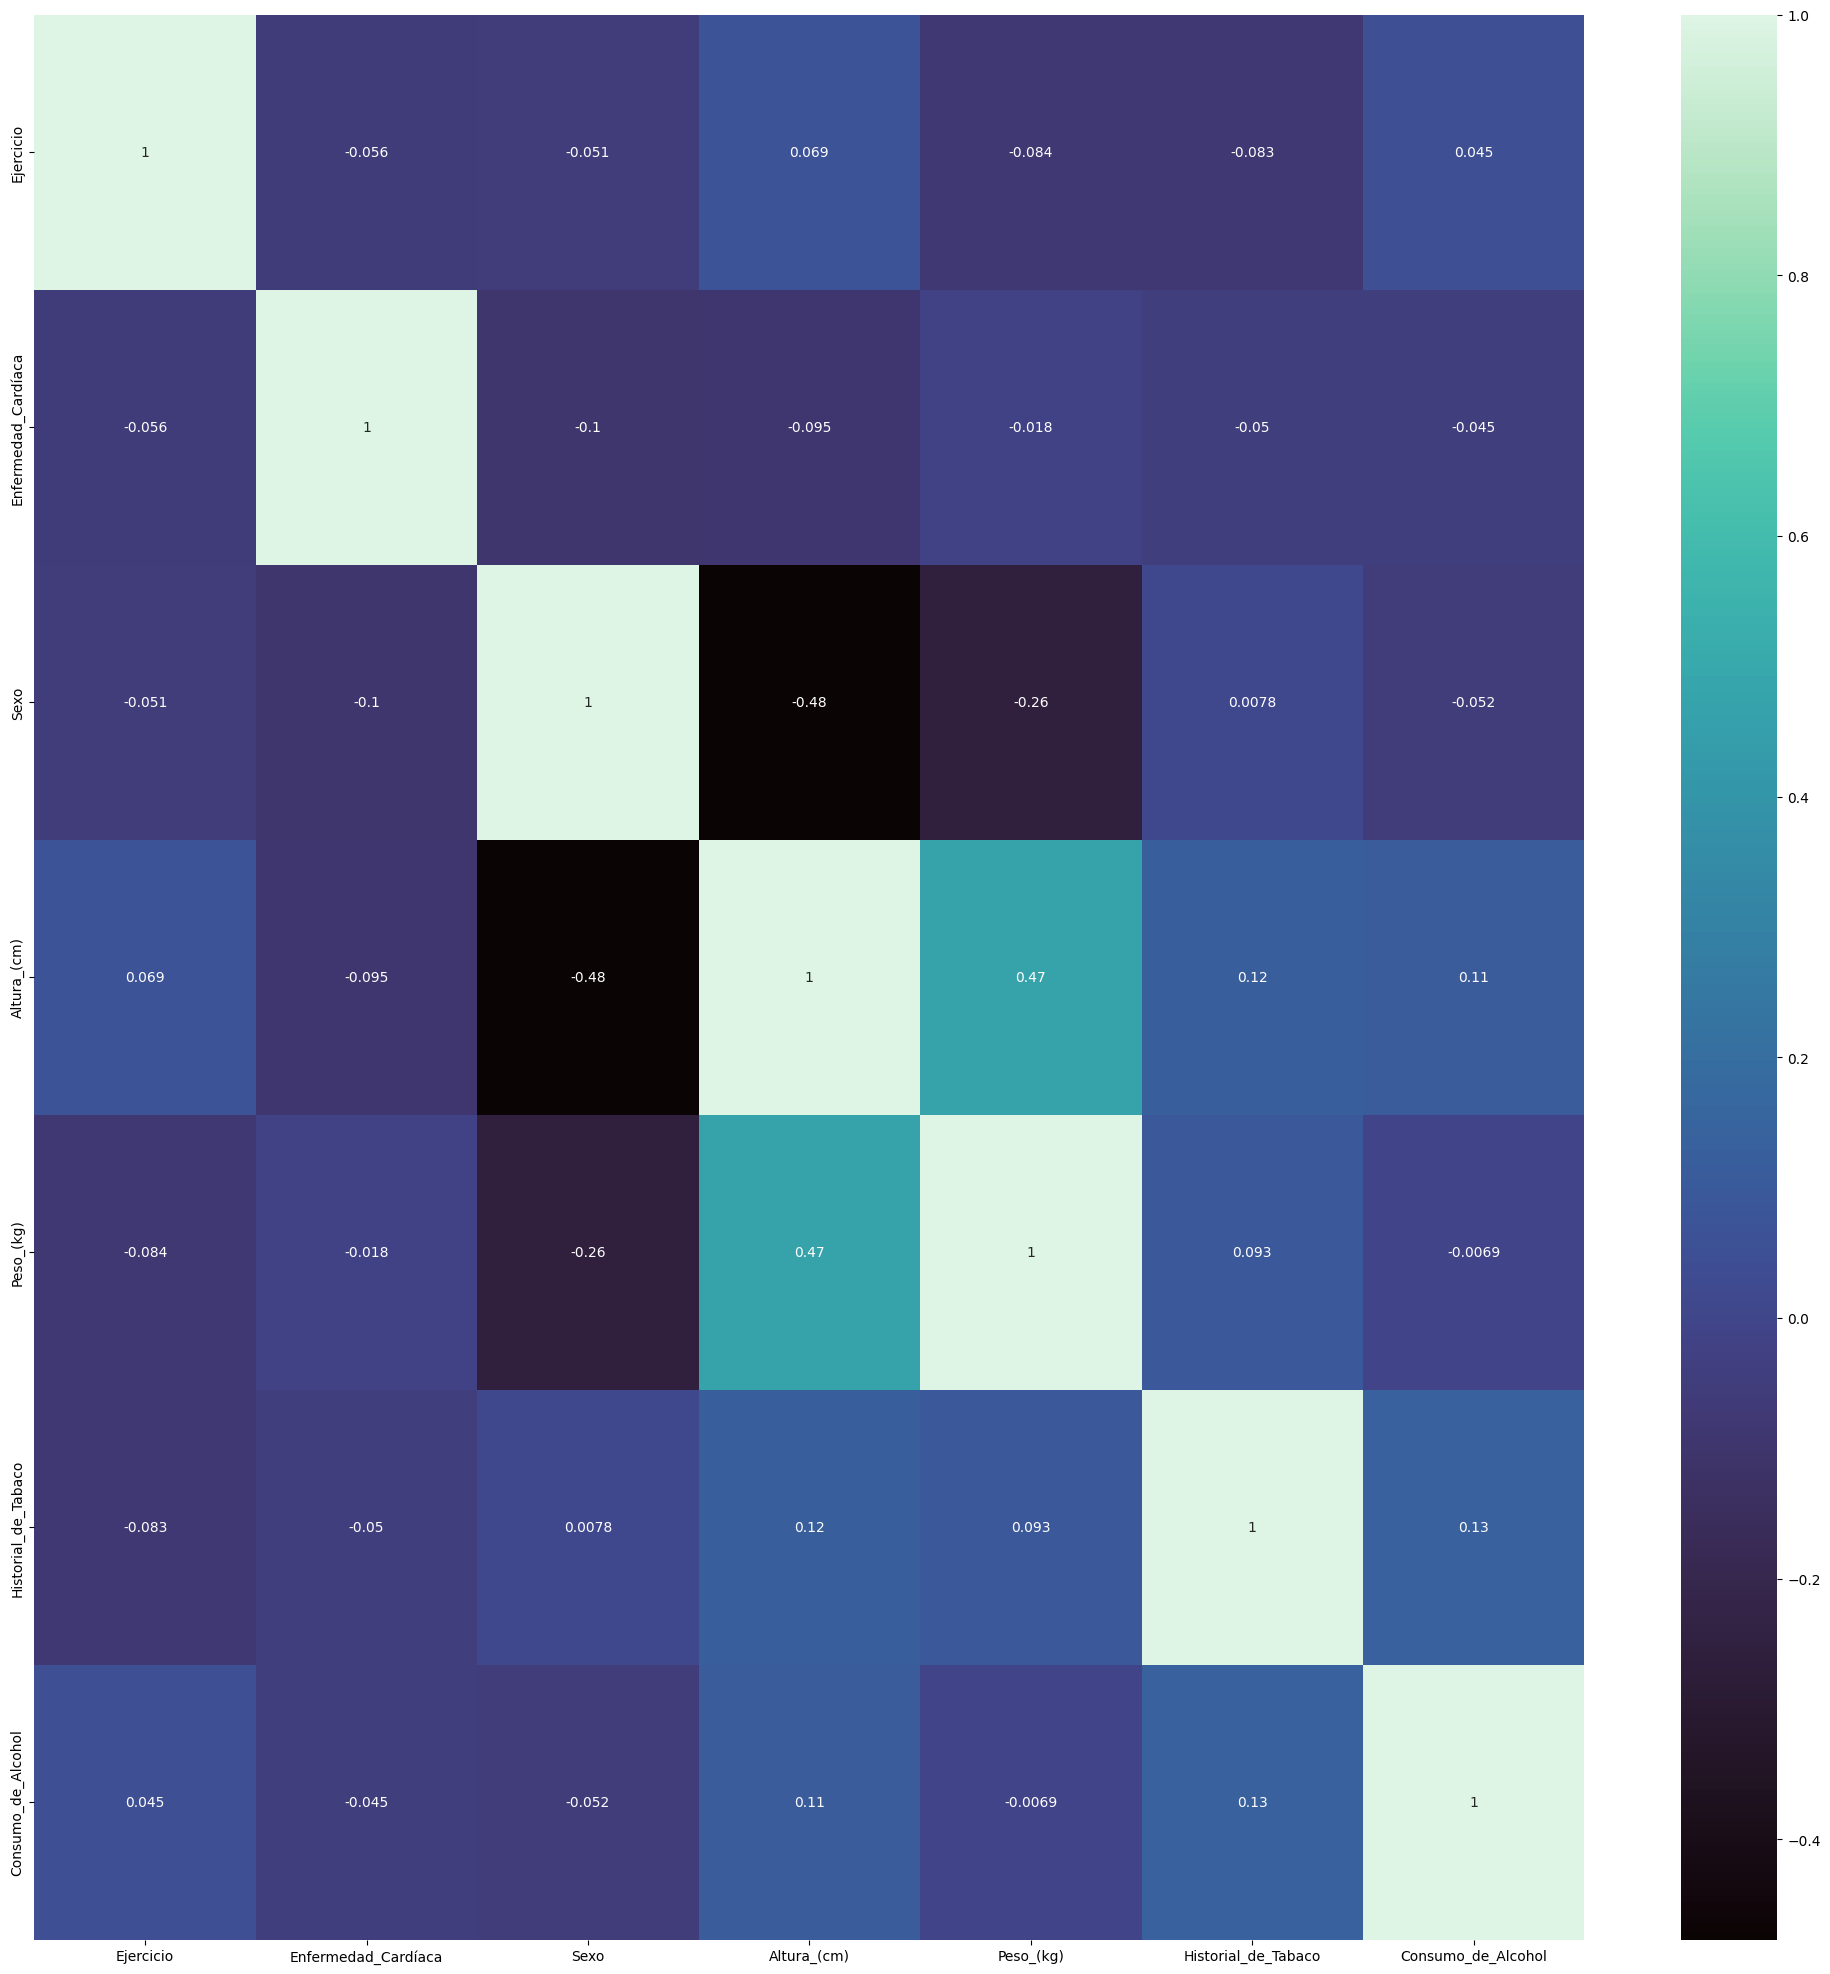

In [81]:
# Plot de matriz de correlación

plt.figure(figsize=(25, 25))
sns.heatmap(data=corr_mat, annot=True, cmap="mako")
plt.show()

In [82]:
correlacion_umbral = 0.005

variables_correlacionadas = set()

# Itera a través de las filas y columnas de la matriz de correlación
for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) >= correlacion_umbral:
            variable1 = corr_mat.columns[i]
            variable2 = corr_mat.columns[j]
            variables_correlacionadas.add((variable1, variable2))

variables_correlacionadas

{('Altura_(cm)', 'Ejercicio'),
 ('Altura_(cm)', 'Enfermedad_Cardíaca'),
 ('Altura_(cm)', 'Sexo'),
 ('Consumo_de_Alcohol', 'Altura_(cm)'),
 ('Consumo_de_Alcohol', 'Ejercicio'),
 ('Consumo_de_Alcohol', 'Enfermedad_Cardíaca'),
 ('Consumo_de_Alcohol', 'Historial_de_Tabaco'),
 ('Consumo_de_Alcohol', 'Peso_(kg)'),
 ('Consumo_de_Alcohol', 'Sexo'),
 ('Enfermedad_Cardíaca', 'Ejercicio'),
 ('Historial_de_Tabaco', 'Altura_(cm)'),
 ('Historial_de_Tabaco', 'Ejercicio'),
 ('Historial_de_Tabaco', 'Enfermedad_Cardíaca'),
 ('Historial_de_Tabaco', 'Peso_(kg)'),
 ('Historial_de_Tabaco', 'Sexo'),
 ('Peso_(kg)', 'Altura_(cm)'),
 ('Peso_(kg)', 'Ejercicio'),
 ('Peso_(kg)', 'Enfermedad_Cardíaca'),
 ('Peso_(kg)', 'Sexo'),
 ('Sexo', 'Ejercicio'),
 ('Sexo', 'Enfermedad_Cardíaca')}

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# Agrega el modelo KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Agrega el modelo Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define los modelos y sus respectivos hiperparámetros
modelos = {
    'Regresión Logística': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'KNeighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    'Naive Bayes': (GaussianNB(), {})
}

In [87]:
resultados = {}

import joblib

mejor_modelo = None
mejor_puntuacion = -1

for nombre_modelo, (modelo, parametros) in tqdm(modelos.items()):
    grid_search = GridSearchCV(
        modelo, parametros, cv=10, scoring='accuracy', error_score='raise')
    grid_search.fit(X_train, y_train)
    resultados[nombre_modelo] = {
        'Mejores Hiperparámetros': grid_search.best_params_,
        'Mejor Puntuación de Validación Cruzada': grid_search.best_score_,
        'Modelo Entrenado': grid_search.best_estimator_
    }

    # Compara la puntuación del modelo actual con la mejor puntuación hasta ahora
    if grid_search.best_score_ > mejor_puntuacion:
        mejor_puntuacion = grid_search.best_score_
        mejor_modelo = grid_search.best_estimator_

# Guarda el mejor modelo
joblib.dump(mejor_modelo, 'mejor_modelo.pkl')

  0%|          | 0/5 [00:00<?, ?it/s]/home/gabcardona0782/anaconda3/envs/Hackaton/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gabcardona0782/anaconda3/envs/Hackaton/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

['mejor_modelo.pkl']

In [88]:
for nombre_modelo, resultado in resultados.items():
    print(f'Modelo: {nombre_modelo}')
    print(f'Mejores Hiperparámetros: {resultado["Mejores Hiperparámetros"]}')
    print(
        f'Mejor Puntuación de Validación Cruzada: {resultado["Mejor Puntuación de Validación Cruzada"]}')
    print('\n')

Modelo: Regresión Logística
Mejores Hiperparámetros: {'C': 10}
Mejor Puntuación de Validación Cruzada: 0.8415328969291886


Modelo: Random Forest
Mejores Hiperparámetros: {'max_depth': 10, 'n_estimators': 100}
Mejor Puntuación de Validación Cruzada: 0.8480601209002543


Modelo: Gradient Boosting
Mejores Hiperparámetros: {'learning_rate': 0.2, 'n_estimators': 200}
Mejor Puntuación de Validación Cruzada: 0.8495269664079318


Modelo: KNeighbors
Mejores Hiperparámetros: {'n_neighbors': 9}
Mejor Puntuación de Validación Cruzada: 0.8443421269658563


Modelo: Naive Bayes
Mejores Hiperparámetros: {}
Mejor Puntuación de Validación Cruzada: 0.8417591452544029




In [90]:
for nombre_modelo, resultado in resultados.items():
    modelo = resultado['Modelo Entrenado']

    # Realiza predicciones en el conjunto de prueba
    y_pred = modelo.predict(X_test)

    # Calcula la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Extrae los valores de TP, FP, TN, FN de la matriz de confusión
    tn, fp, fn, tp = cm.ravel()

    # Calcula métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Imprime los valores de TP, FP, TN, FN
    print(f'Modelo: {nombre_modelo}')
    print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

    # Gráfica la matriz de confusión con Seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5)
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')

    # Muestra las métricas en el título
    plt.title(
        f'Matriz de Confusión - {nombre_modelo}\nAccuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1-Score={f1:.2f}')

    plt.tight_layout()
    plt.show()

ValueError: pos_label=2 is not a valid label. It should be one of [0, 1]

In [40]:
import pickle

nombre_archivo_modelo = 'mejor_modelo.pkl'

# Guardar el modelo en el archivo usando pickle
with open(nombre_archivo_modelo, 'wb') as archivo:
    pickle.dump(grid_search.best_estimator_, archivo)

In [41]:
import pickle
# Luego, para cargar el modelo desde el archivo puedes usar:
with open('mejor_modelo.pkl', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

In [42]:
X_test.iloc[0]

Ejercicio              0.530530
Sexo                   1.025458
Altura_(cm)           -1.182831
Peso_(kg)             -1.223200
Historial_de_Tabaco   -0.728843
Consumo_de_Alcohol    -0.343149
Name: 180938, dtype: float64

In [43]:
y_test.iloc[0]

0

In [47]:
nuevos_datos = {
    'Ejercicio': [1],
    'Sexo': [1],
    'Altura_(cm)': [160],
    'Peso_(kg)': [90],
    'Historial_de_Tabaco': [1],
    'Consumo_de_Alcohol': [1]
}

nuevos_datos_sc = scaler.transform(pd.DataFrame(nuevos_datos))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Enfermedad_Cardíaca


In [45]:
prediccion = modelo_cargado.predict(nuevos_datos)
print(prediccion)

[0]
